In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [2]:
from run_functions import *
from agent_functions import *
from plot_functions import *

In [3]:
from routing_networks import *
from recommenders import *

## Heuristic Recommeder Sandbox

In [4]:
def heuristic_recommender(Q, n_agents):
    S = np.zeros(n_agents)
    flexible = []
    force_up = []
    force_down = []
    force_cross = []
    arg_max_Q = np.argmax(Q, axis=2)

    for i, argmax_q_table in enumerate(arg_max_Q):
        if 0 in argmax_q_table:  # could the agent go up?
            if 1 in argmax_q_table: # could the agent go down?
                flexible.append(i)  # if both, store for later assignment
#                 print(i, "flexible", argmax_q_table)
            else:
                force_up.append(i)  # if only up, assign agent to go up
#                 print(i, "up", argmax_q_table)
        elif 1 in argmax_q_table:
                force_down.append(i) # if only down, assign agent to go down
#                 print(i, "down", argmax_q_table)
        else:
            force_cross.append(i) # add logic for sure crossers
#             print(i, "cross", argmax_q_table)
    
#     print("force up", force_up)
#     print("force down", force_down)
#     print("force cross", force_cross)
#     print("flexible", flexible)
    
    n_flexible = len(flexible)
    n_up = len(force_up)
    n_down = len(force_down)
    n_cross = len(force_cross)
    
#     print(n_up, n_down, n_cross, n_flexible)
#     print("flexible \n", flexible)
    diff_up_down = n_up - n_down
    
    if abs(diff_up_down) >= n_flexible:
        if diff_up_down > 0:
            # assign all flexible to down
            while len(flexible) > 0: force_down.append(flexible.pop())
        else:
            # assign all flexible to up
            while len(flexible) > 0: force_up.append(flexible.pop())
                
    elif abs(diff_up_down) < n_flexible:
        if diff_up_down > 0:
            # assign #diff_up_down flexible to down
            for x in range(abs(diff_up_down)): force_down.append(flexible.pop())
        else:
            # assign #diff_up_down flexible to up
            for x in range(abs(diff_up_down)): force_up.append(flexible.pop())
                
        # split remaining flexible up and down equally
        counter = 0
        while len(flexible) > 0:
            if counter%2 == 0:
                force_down.append(flexible.pop())
            else:
                force_up.append(flexible.pop())
            counter += 1
    
#     print("force up", force_up)
#     print("force down", force_down)
#     print("force cross", force_cross)
#     print("flexible", flexible)
    
    travel_time_estimate = [
        1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # up 
        1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # down
        1+n_cross/n_agents                          # cross
    ]
    
    for i in force_up:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==0).flatten()
#         print(recommendations_that_force)
        belief_differences = - travel_time_estimate[0] - Q[i, recommendations_that_force, 0]
#         if len(belief_differences) == 0:
#             print(i, " has len 0")
        best_recommendation = np.argmax(belief_differences)
#         print(best_recommendation)
        S[i] = recommendations_that_force[best_recommendation]
    
    for i in force_down:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==1).flatten()
        belief_differences = - travel_time_estimate[1] - Q[i, recommendations_that_force, 1]
        best_recommendation = np.argmax(belief_differences)
        S[i] = recommendations_that_force[best_recommendation]
    
    for i in force_cross:
        recommendations_that_force = np.argwhere(arg_max_Q[i]==2).flatten()
        belief_differences = - travel_time_estimate[2] - Q[i, recommendations_that_force, 2]
        best_recommendation = np.argmin(belief_differences)
        S[i] = recommendations_that_force[best_recommendation]
        
    return S.astype(int)

In [4]:
def split_up_down_cross_flexible(arg_max_Q):
    up = []
    down = []
    cross = []
    flexible = []
    
    for i, argmax_q_table in enumerate(arg_max_Q):
        if 0 in argmax_q_table:  # could the agent go up?
            if 1 in argmax_q_table: # could the agent go down?
                flexible.append(i)  # if both, store for later assignment
            else:
                up.append(i)  # if only up, assign agent to go up
        elif 1 in argmax_q_table:
                down.append(i) # if only down, assign agent to go down
        else:
            cross.append(i) # add logic for sure crossers

    return up, down, cross, flexible

In [ ]:
def belief_improvement(Q, travel_time_estimate, action, indices, states):

In [6]:
# def sort_by_belief_difference(Q, arg_max_Q, agent_indices, action):
    
#     ind, state = np.where(arg_max_Q[agent_indices] == action)
    
#     values = Q[agent_indices][ind, state, action] - Q[agent_indices][ind, state, 2]
    
#     structured_array = np.array(
#         list(zip(values, ind, state)),
#         dtype = [("belief_diff", float), ("index", int), ("state", int)]
#         )
#     structured_array.sort(order="belief_diff")
    
#     sorted_agent_indices = []
#     sorted_agent_recommendations = []

#     for agent in reversed(structured_array):
#         agent_index = agent_indices[agent[1]]
#         recommendation = agent[2]
#         if agent_index in sorted_agent_indices:
#             continue
#         else:
#             sorted_agent_indices.append(agent_index)
#             sorted_agent_recommendations.append(recommendation) 
            
#     return sorted_agent_indices, sorted_agent_recommendations

In [5]:
def sort_by_belief_improvement(Q, arg_max_Q, agent_indices, action, method, travel_time_estimate, minimize=False):
    
    coefficient = -1 if minimize else 1
    
    ind, state = np.where(arg_max_Q[agent_indices] == action)
    
    target = travel_time_estimate[action] if method == "estimate" else Q[agent_indices][ind, state, 2]
    
    values = coefficient * (- target - Q[agent_indices][ind, state, action])
    
    structured_array = np.array(
        list(zip(values, ind, state)),
        dtype = [("belief_diff", float), ("index", int), ("state", int)]
        )
    structured_array.sort(order="belief_diff")
    
    sorted_agent_indices = []
    sorted_agent_recommendations = []

    for agent in reversed(structured_array):
        agent_index = agent_indices[agent[1]]
        recommendation = agent[2]
        if agent_index in sorted_agent_indices:
            continue
        else:
            sorted_agent_indices.append(agent_index)
            sorted_agent_recommendations.append(recommendation) 
            
    return sorted_agent_indices, sorted_agent_recommendations

In [6]:
def assign_crossers(S, arg_max_Q, agent_indices, travel_time_estimate):
    
    cross=2
    
    ind, state = np.where(arg_max_Q[agent_indices] == cross)
    
    values_0 = Q[agent_indices][ind, state, cross] - Q[agent_indices][ind, state, 0]
    values_1 = Q[agent_indices][ind, state, cross] - Q[agent_indices][ind, state, 1]
    
#     values_0 = - travel_time_estimate[cross] - Q[agent_indices][ind, state, 0]
#     values_1 = - travel_time_estimate[cross] - Q[agent_indices][ind, state, 1]
    
    
    structured_array_0 = np.array(
        list(zip(values_0, ind, state)),
        dtype = [("belief_diff", float), ("index", int), ("state", int)]
        )
    structured_array_1 = np.array(
        list(zip(values_1, ind, state)),
        dtype = [("belief_diff", float), ("index", int), ("state", int)]
        )
    structured_array = np.concatenate((structured_array_0, structured_array_1))
    structured_array.sort(order="belief_diff")
    
    sorted_agent_indices = []
    sorted_agent_recommendations = []
    
    for agent in reversed(structured_array):
        agent_index = agent_indices[agent[1]]
        recommendation = agent[2]
        if agent_index in sorted_agent_indices:
            continue
        else:
            sorted_agent_indices.append(agent_index)
            sorted_agent_recommendations.append(recommendation) 
            
    while len(sorted_agent_indices) > 0:
        S[sorted_agent_indices.pop()] = sorted_agent_recommendations.pop()
    return S

In [303]:
def assign_flexible_to_up_down(S, force_up, force_down, flexible, Q, arg_max_Q, method, estimate, minimize=False):
    n_flexible = len(flexible)
    n_up = len(force_up)
    n_down = len(force_down)
    diff_up_down = n_up - n_down
    minority = 1 if diff_up_down >= 0 else 0
    
    sorted_flexible, flexible_recommendation = sort_by_belief_improvement(
        Q, arg_max_Q, flexible, minority, method, estimate, minimize=minimize)
    
    if abs(diff_up_down) >= n_flexible:
        
        while len(sorted_flexible) > 0: 
            S[sorted_flexible.pop()] = flexible_recommendation.pop()
                
    elif abs(diff_up_down) < n_flexible:
        
        for x in range(abs(diff_up_down) + int((n_flexible - abs(diff_up_down))/2)): 

            S[sorted_flexible.pop()] = flexible_recommendation.pop()
        
        sorted_majority, majority_recommendation = sort_by_belief_improvement(
            Q, arg_max_Q, sorted_flexible, abs(1-minority), method, estimate, minimize=minimize)
        
        while len(sorted_majority) > 0: 
            S[sorted_majority.pop()] = majority_recommendation.pop()
            
    return S

In [304]:
def assign(S, Q, arg_max_Q, agent_indices, action, method, estimate, minimize=False):
#     sorted_agent_indices, sorted_agent_recommendations = sort_by_belief_difference(
#         Q, arg_max_Q, agent_indices, action)

    sorted_agent_indices, sorted_agent_recommendations = sort_by_belief_improvement(
        Q, arg_max_Q, agent_indices, action, method, estimate, minimize=minimize)
    
    while len(sorted_agent_indices) > 0:
        S[sorted_agent_indices.pop()] = sorted_agent_recommendations.pop()
    return S

In [305]:
def calculate_travel_time_estimate(n_cross, n_agents):
    return [
            1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # up 
            1+(1-n_cross/n_agents)/2+n_cross/n_agents,  # down
            1+n_cross/n_agents                          # cross
            ]

In [310]:
def optimized_heuristic_recommender(Q, n_agents, method="estimate", minimize=False):
    S = np.zeros(n_agents)
    arg_max_Q = np.argmax(Q, axis=2)
    
    up, down, cross, flexible = split_up_down_cross_flexible(arg_max_Q)
    
    estimate = calculate_travel_time_estimate(len(cross), n_agents)
    
    assign_flexible_to_up_down(S, up, down, flexible, Q, arg_max_Q, method, estimate, minimize)
    
    S = assign(S, Q, arg_max_Q, up, 0, method, estimate, minimize)
    S = assign(S, Q, arg_max_Q, down, 1, method, estimate, minimize)
#     S = assign_crossers(S, arg_max_Q, cross)
    S = assign(S, Q, arg_max_Q, cross, 2, method, estimate, (not minimize))
    
    return S.astype(int)

In [287]:
# def optimized_heuristic_recommender(Q, n_agents, method="estimate", minimize=False):
#     S = np.zeros(n_agents)
#     arg_max_Q = np.argmax(Q, axis=2)
    
#     up, down, cross, flexible = split_up_down_cross_flexible(arg_max_Q)
    
#     estimate = calculate_travel_time_estimate(len(cross), n_agents)
    
#     assign_flexible_to_up_down(S, up, down, flexible, Q, arg_max_Q, method, estimate, minimize)
    
#     S = assign(S, Q, arg_max_Q, up, 0, method, estimate, minimize)
#     S = assign(S, Q, arg_max_Q, down, 1, method, estimate, minimize)
# #     S = assign_crossers(S, arg_max_Q, cross)
# #     S = assign(S, Q, arg_max_Q, cross, 2, method, estimate, (not minimize))
#     action = (-(- np.array(travel_time_estimate) - Q[cross].max(axis=2))).mean(axis=0).argmax()
#     S[cross] = action
    
#     return S.astype(int)

In [ ]:
# for i in up:
#         recommendations_that_force = np.argwhere(arg_max_Q[i]==0).flatten()
# #         print(recommendations_that_force)
#         belief_differences = - travel_time_estimate[0] - Q[i, recommendations_that_force, 0]
# #         if len(belief_differences) == 0:
# #             print(i, " has len 0")
#         best_recommendation = np.argmax(belief_differences)
# #         print(best_recommendation)
#         S[i] = recommendations_that_force[best_recommendation]
    
#     for i in down:
#         recommendations_that_force = np.argwhere(arg_max_Q[i]==1).flatten()
#         belief_differences = - travel_time_estimate[1] - Q[i, recommendations_that_force, 1]
#         best_recommendation = np.argmax(belief_differences)
#         S[i] = recommendations_that_force[best_recommendation]
    
#     for i in cross:
#         recommendations_that_force = np.argwhere(arg_max_Q[i]==2).flatten()
#         belief_differences = - travel_time_estimate[2] - Q[i, recommendations_that_force, 2]
#         best_recommendation = np.argmin(belief_differences)
#         S[i] = recommendations_that_force[best_recommendation]

## Aligned Recommender Sandbox

In [129]:
n_agents = 100
Q = initialize_q_table("UNIFORM", n_agents, 3, 3)

In [130]:
Q

array([[[-1.31824708, -1.61526473, -1.43068242],
        [-1.05998833, -1.30130327, -1.73742856],
        [-1.13418018, -1.18214316, -1.64733541]],

       [[-1.96021527, -1.7312435 , -1.81937639],
        [-1.8534726 , -1.14916389, -1.72195208],
        [-1.83564778, -1.13939697, -1.40712584]],

       [[-1.60610972, -1.43121116, -1.53669258],
        [-1.45643154, -1.6035407 , -1.16596461],
        [-1.28621437, -1.54785807, -1.11736891]],

       [[-1.465154  , -1.80078011, -1.27074422],
        [-1.74147862, -1.74504484, -1.50222505],
        [-1.73777209, -1.16836351, -1.1127015 ]],

       [[-1.17483305, -1.45282073, -1.71618441],
        [-1.49167497, -1.53359262, -1.76961853],
        [-1.8710262 , -1.33370715, -1.2256595 ]],

       [[-1.04448284, -1.21124354, -1.94264612],
        [-1.56161176, -1.59764971, -1.87661623],
        [-1.18816825, -1.22661101, -1.77650319]],

       [[-1.13647127, -1.85438471, -1.29132519],
        [-1.48765106, -1.29546654, -1.76525935],
        

In [131]:
S = np.zeros(n_agents)
flexible = []
force_up = []
force_down = []
force_cross = []
arg_max_Q = np.argmax(Q, axis=2)
alignment_table = arg_max_Q[:,:3] == np.broadcast_to(np.arange(3), (n_agents, 3))  # alignment of up and down, only
print(alignment_table)

[[ True False False]
 [False  True False]
 [False False  True]
 [False False  True]
 [ True False  True]
 [ True False False]
 [ True  True False]
 [False  True False]
 [False  True False]
 [False  True  True]
 [ True  True  True]
 [False False  True]
 [ True False False]
 [False False  True]
 [False False False]
 [False False False]
 [False  True False]
 [False  True  True]
 [False  True False]
 [ True False  True]
 [False False False]
 [False False False]
 [False False False]
 [ True False False]
 [False False False]
 [False  True  True]
 [ True False False]
 [False  True False]
 [False False False]
 [False  True False]
 [False  True False]
 [ True False False]
 [False False False]
 [ True False False]
 [ True False  True]
 [False False False]
 [False False False]
 [False False False]
 [ True False  True]
 [ True False False]
 [False  True  True]
 [False False False]
 [False False  True]
 [False False False]
 [False False False]
 [False  True False]
 [ True False  True]
 [False False

In [132]:
aligned_both = []
aligned_up = []
aligned_down = []
aligned_cross = []
misaligned = []

for i, alignings in enumerate(alignment_table):
        if alignings[0]:  # could the agent go up?
            if alignings[1]: # could the agent go down?
                aligned_both.append(i)  # if both, store for later assignment
#                 print(i, "flexible", argmax_q_table)
            else:
                aligned_up.append(i)  # if only up, assign agent to go up
#                 print(i, "up", argmax_q_table)
        elif alignings[1]:
                aligned_down.append(i) # if only down, assign agent to go down
#                 print(i, "down", argmax_q_table)
        elif alignings[2]:
            aligned_cross.append(i) # add logic for sure crossers
#             print(i, "cross", argmax_q_table)
        else:
            misaligned.append(i)

print("force up", aligned_up)
print("force down", aligned_down)
print("force cross", aligned_cross)
print("flexible", aligned_both)
print("misaligned", misaligned)

force up [0, 4, 5, 12, 19, 23, 26, 31, 33, 34, 38, 39, 46, 52, 63, 64, 77, 79, 80, 82, 86, 97]
force down [1, 7, 8, 9, 16, 17, 18, 25, 27, 29, 30, 40, 45, 48, 49, 50, 58, 59, 60, 67, 69, 83, 87, 90, 92, 93, 96]
force cross [2, 3, 11, 13, 42, 47, 51, 54, 61, 62, 65, 66, 72, 73, 76, 78, 81, 84, 88, 89, 91, 94]
flexible [6, 10, 57, 68, 95, 99]
misaligned [14, 15, 20, 21, 22, 24, 28, 32, 35, 36, 37, 41, 43, 44, 53, 55, 56, 70, 71, 74, 75, 85, 98]


In [133]:
for i in aligned_up: S[i] = 0

for i in aligned_down: S[i] = 1

for i in aligned_cross: S[i] = 2
    
S

array([0., 1., 2., 2., 0., 0., 0., 1., 1., 1., 0., 2., 0., 2., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 1., 0., 2., 1., 1., 1.,
       2., 0., 0., 2., 0., 0., 0., 1., 1., 1., 2., 2., 0., 0., 2., 2., 1.,
       0., 1., 0., 0., 2., 2., 0., 0., 2., 0., 2., 0., 0., 2., 0., 1., 2.,
       0., 0., 1., 2., 2., 1., 2., 1., 1., 2., 0., 1., 0., 0., 0.])

In [134]:
np.bincount(S.astype(int))

array([51, 27, 22])

In [135]:
n_cross = len(aligned_cross)+len(misaligned)
n_cross

45

In [136]:
travel_time_estimate = calculate_travel_time_estimate(n_cross, n_agents)

In [173]:
for i in misaligned:
#     misaligned_belief_distance = np.max(Q[i], axis=1) - Q[i].diagonal()
    belief_difference_from_estimate = -(- np.array(travel_time_estimate) - np.max(Q[i], axis=1))
    S[i] = np.argmax(belief_difference_from_estimate)
misaligned, belief_difference_from_estimate

([14,
  15,
  20,
  21,
  22,
  24,
  28,
  32,
  35,
  36,
  37,
  41,
  43,
  44,
  53,
  55,
  56,
  70,
  71,
  74,
  75,
  85,
  98],
 array([ 0.12658989, -0.2239795 , -0.4845    ]))

In [ ]:
# the process below is supposed to find the recommendation whos max is furthest from the estimate and closest to
# the correctly aligned action for the recommendation

In [ ]:
belief_difference_from_estimate = np.array([-(-np.array(travel_time_estimate) - np.max(Q[i], axis=1) - Q[i].diagonal()) for i in range(n_agents)])
S = np.argmax(belief_difference_from_estimate, axis=1)

In [ ]:
np.max(Q[i], axis=1), Q[i], Q[i].diagonal(), 

In [ ]:
belief_difference_from_estimate.shape

In [138]:
diff_up_down = len(aligned_up) - len(aligned_down)
n_flexible = len(aligned_both)
print(n_flexible)

if abs(diff_up_down) >= n_flexible > 0:
    if diff_up_down > 0:
        # assign all flexible to down
        while len(aligned_both) > 0: S[aligned_both.pop()] = 1
    else:
        # assign all flexible to up
        while len(aligned_both) > 0: S[aligned_both.pop()] = 0

elif abs(diff_up_down) < n_flexible > 0:
    if diff_up_down > 0:
        # assign #diff_up_down flexible to down
        for x in range(abs(diff_up_down)): S[aligned_both.pop()] = 1
    else:
        # assign #diff_up_down flexible to up
        for x in range(abs(diff_up_down)): S[aligned_both.pop()] = 0

    # split remaining flexible up and down equally
    counter = 0
    while len(aligned_both) > 0:
        if counter%2 == 0:
            S[aligned_both.pop()] = 1
        else:
            S[aligned_both.pop()] = 0
        counter += 1

6


In [139]:
S = S.astype(int)

In [140]:
recommendation_alignment = (S == arg_max_Q[np.arange(Q.shape[0]), S])
recommendation_alignment, recommendation_alignment.mean()

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True, False, False, False,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True, False,
        False, False,  True,  True,  True, False,  True, False, False,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True]),
 0.77)

In [273]:
def aligned_heuristic_recommender(Q, n_agents):
    S = np.zeros(n_agents)
    arg_max_Q = np.argmax(Q, axis=2)
    alignment_table = arg_max_Q[:,:3] == np.broadcast_to(np.arange(3), (n_agents, 3))  # alignment of up and down, only
    
    aligned_both = []
    aligned_up = []
    aligned_down = []
    aligned_cross = []
    misaligned = []
    
    up = 0
    down = 1
    cross = 2
    
    for i, alignings in enumerate(alignment_table):
        if alignings[up]:  # could the agent go up?
            if alignings[down]: # could the agent also go down?
                aligned_both.append(i)  # if both, store for later assignment
            else:
                aligned_up.append(i)  # if only up, assign agent to go up
        elif alignings[down]:
                aligned_down.append(i) # if only down, assign agent to go down
        elif alignings[cross]:
            aligned_cross.append(i)
        else:
            misaligned.append(i)
    
    n_tuple = (len(aligned_up), len(aligned_down), len(aligned_cross), len(aligned_both), len(misaligned))
    
    n_cross = len(aligned_cross) + int(len(misaligned))  # optimistic estimate of crossers

    travel_time_estimate = calculate_travel_time_estimate(n_cross, n_agents)
        
    # assign all aligned recommendations possible
    S[aligned_up] = up
    S[aligned_down] = down
    S[aligned_cross] = cross
    
    # ASSIGN FLEXIBLE AGENTS
    diff_up_down = len(aligned_up) - len(aligned_down)
    n_flexible = len(aligned_both)
    if abs(diff_up_down) >= n_flexible and n_flexible > 0:
        if diff_up_down > 0:
            # assign all flexible to down
            while len(aligned_both) > 0: S[aligned_both.pop()] = down
        else:
            # assign all flexible to up
            while len(aligned_both) > 0: S[aligned_both.pop()] = up
    elif abs(diff_up_down) < n_flexible and n_flexible > 0:
        if diff_up_down > 0:
            # assign #diff_up_down flexible to down
            for x in range(abs(diff_up_down)): S[aligned_both.pop()] = down
        else:
            # assign #diff_up_down flexible to up
            for x in range(abs(diff_up_down)): S[aligned_both.pop()] = up
        # split remaining flexible up and down equally
        counter = np.random.randint(0, 1)
        while len(aligned_both) > 0:
            if counter%2 == 0:
                S[aligned_both.pop()] = down
            else:
                S[aligned_both.pop()] = up
            counter += 1
        
#     # ASSIGN MISALIGNED AGENTS
#     for i, amax in list(zip(misaligned, arg_max_Q[misaligned])):
#         if amax[up] == cross:
#             if amax[down] == cross:
#                 S[i] = np.argmin([Q[i,up,cross]-Q[i,up,up], Q[i,down,cross]-Q[i,down,down]])
#             else:
#                 S[i] = up
#         elif amax[down] == cross:
#             S[i] = down
#         else:
#             S[i] = cross
    
#     random_agent = 10 #np.random.randint(N_AGENTS)
#     for i in misaligned:
# #         misaligned_belief_distance = np.max(Q[i], axis=1) - Q[i].diagonal()
#         belief_difference_from_estimate = -(- np.array(travel_time_estimate) - np.max(Q[random_agent], axis=1))
#         S[i] = np.argmax(belief_difference_from_estimate)
    
    action = (-(- np.array(travel_time_estimate) - Q.max(axis=2))).mean(axis=0).argmax()
    S[misaligned] = action
    
#     random_action = np.random.randint(up,down)
#     for i in misaligned: S[i] = random_action
    
#     for i in misaligned:
#     #     misaligned_belief_distance = np.max(Q[i], axis=1) - Q[i].diagonal()
#         belief_difference_from_estimate = -(- np.array(travel_time_estimate) - np.max(Q[i], axis=1))
#         S[i] = np.argmax(belief_difference_from_estimate)
    
    return S.astype(int), n_tuple

In [294]:
def aligned_heuristic_recommender(Q, n_agents):
    S = np.zeros(n_agents)
    arg_max_Q = np.argmax(Q, axis=2)
    alignment_table = arg_max_Q[:,:3] == np.broadcast_to(np.arange(3), (n_agents, 3))  # alignment of up and down, only
    
    aligned_both = []
    aligned_up = []
    aligned_down = []
    aligned_cross = []
    misaligned = []
    
    up = 0
    down = 1
    cross = 2
    
    for i, alignings in enumerate(alignment_table):
        if alignings[up]:  # could the agent go up?
            if alignings[down]: # could the agent also go down?
                aligned_both.append(i)  # if both, store for later assignment
            else:
                aligned_up.append(i)  # if only up, assign agent to go up
        elif alignings[down]:
                aligned_down.append(i) # if only down, assign agent to go down
        elif alignings[cross]:
            aligned_cross.append(i)
        else:
            misaligned.append(i)
    
    n_tuple = (len(aligned_up), len(aligned_down), len(aligned_cross), len(aligned_both), len(misaligned))
    
    n_cross = len(aligned_cross) + int(len(misaligned))  # pessimistic estimate of crossers

    travel_time_estimate = calculate_travel_time_estimate(n_cross, n_agents)
        
    # assign all aligned recommendations possible
    S[aligned_up] = up
    S[aligned_down] = down
    S[aligned_cross] = cross
    
    # ASSIGN FLEXIBLE AGENTS
    diff_up_down = len(aligned_up) - len(aligned_down)
    n_flexible = len(aligned_both)
    if abs(diff_up_down) >= n_flexible and n_flexible > 0:
        if diff_up_down > 0:
            # assign all flexible to down
            while len(aligned_both) > 0: S[aligned_both.pop()] = down
        else:
            # assign all flexible to up
            while len(aligned_both) > 0: S[aligned_both.pop()] = up
    elif abs(diff_up_down) < n_flexible and n_flexible > 0:
        if diff_up_down > 0:
            # assign #diff_up_down flexible to down
            for x in range(abs(diff_up_down)): S[aligned_both.pop()] = down
        else:
            # assign #diff_up_down flexible to up
            for x in range(abs(diff_up_down)): S[aligned_both.pop()] = up
        # split remaining flexible up and down equally
        counter = np.random.randint(0, 1)
        while len(aligned_both) > 0:
            if counter%2 == 0:
                S[aligned_both.pop()] = down
            else:
                S[aligned_both.pop()] = up
            counter += 1
        
#     # ASSIGN MISALIGNED AGENTS
#     for i, amax in list(zip(misaligned, arg_max_Q[misaligned])):
#         if amax[up] == cross:
#             if amax[down] == cross:
#                 S[i] = np.argmin([Q[i,up,cross]-Q[i,up,up], Q[i,down,cross]-Q[i,down,down]])
#             else:
#                 S[i] = up
#         elif amax[down] == cross:
#             S[i] = down
#         else:
#             S[i] = cross
    
#     random_agent = 10 #np.random.randint(N_AGENTS)
#     for i in misaligned:
# #         misaligned_belief_distance = np.max(Q[i], axis=1) - Q[i].diagonal()
#         belief_difference_from_estimate = -(- np.array(travel_time_estimate) - np.max(Q[random_agent], axis=1))
#         S[i] = np.argmax(belief_difference_from_estimate)
    
    action = (-(- np.array(travel_time_estimate) - Q.max(axis=2))).mean(axis=0).argmax()
    S[misaligned] = action
    
#     random_action = np.random.randint(up,down)
#     for i in misaligned: S[i] = random_action
    
    return S.astype(int), n_tuple

### Testing Braess Recommenders

In [295]:
def calculate_alignment(q_table, recommendation, actions):
    argmax_q_table = np.argmax(q_table, axis=2)
    belief_alignment = (argmax_q_table == np.broadcast_to(np.arange(q_table.shape[2]), (q_table.shape[0], q_table.shape[1]))).mean(axis=0)
    recommendation_alignment = (recommendation == argmax_q_table[np.arange(q_table.shape[0]), recommendation]).mean()
    action_alignment = (recommendation==actions).mean()
    return belief_alignment, recommendation_alignment, action_alignment

In [307]:
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 10000

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.01

QINIT = "UNIFORM"  # np.array([-2, -2, -2])

In [308]:
%%time
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S, n_tuple = aligned_heuristic_recommender(Q, N_AGENTS)
    S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=False)
    
    A = e_greedy_select_action(Q, S, EPSILON)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    R, travel_time_per_route = braess_augmented_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
            "n_tuple": n_tuple
           }

CPU times: user 16.7 s, sys: 50.3 ms, total: 16.8 s
Wall time: 16.8 s


aligned_heuristic_low_alpha


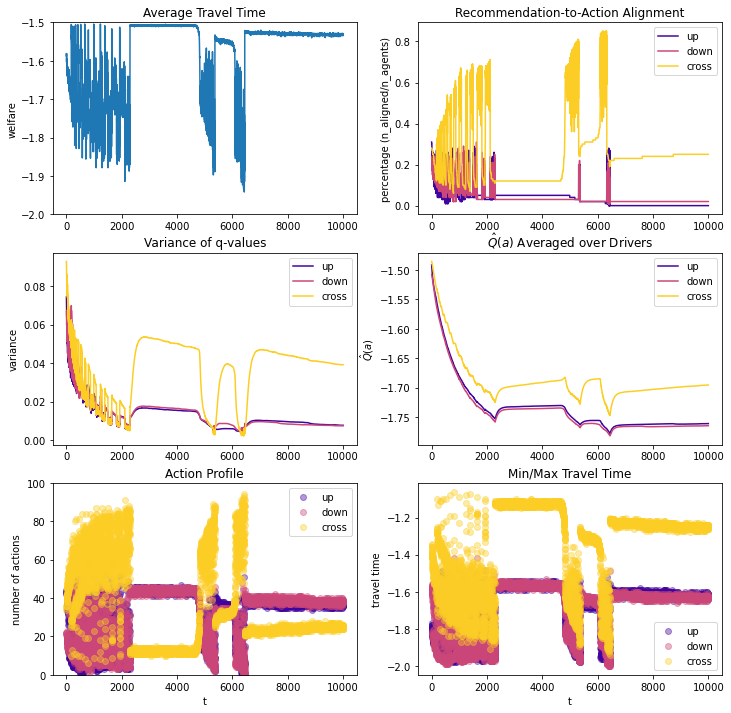

In [298]:
plot_run(M, "aligned_heuristic_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

(0.0, 1.1)

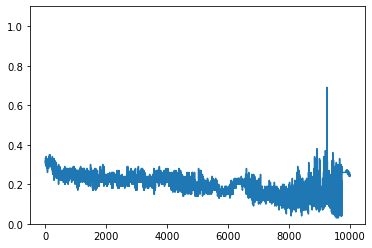

In [301]:
plt.plot([M[t]["recommendation_alignment"] for t in range(N_ITER)])
plt.ylim((0,1.1))

(-1.0, 101.0)

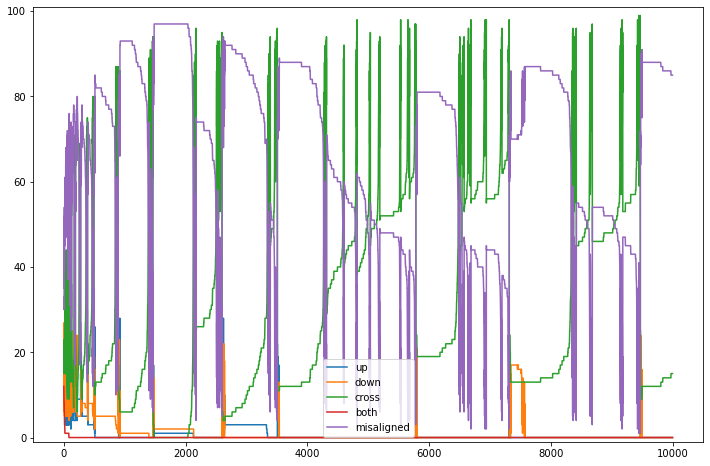

In [258]:
plt.figure(figsize=(12, 8))
plt.plot([M[t]["n_tuple"] for t in range(N_ITER)], label=["up", "down", "cross", "both", "misaligned"])
plt.legend()
plt.ylim((-1,101))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-1.0, 101.0)

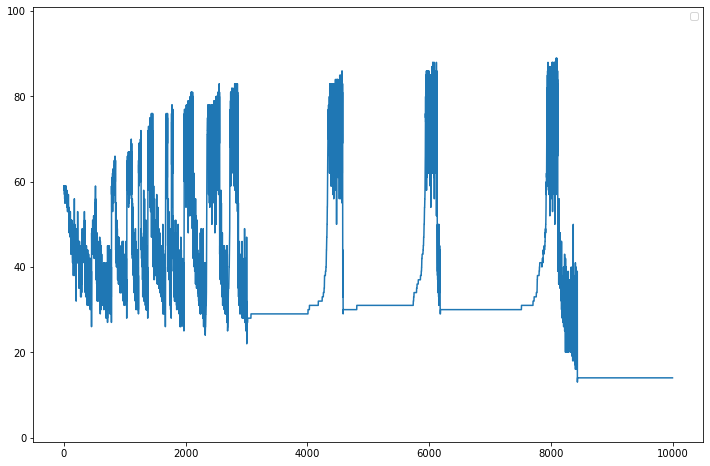

In [286]:
plt.figure(figsize=(12, 8))
plt.plot([M[t]["n_tuple"][0]+M[t]["n_tuple"][1]+M[t]["n_tuple"][2] for t in range(N_ITER)])  #, label=["up", "down", "cross", "both", "misaligned"])
plt.legend()
plt.ylim((-1,101))

heuristic


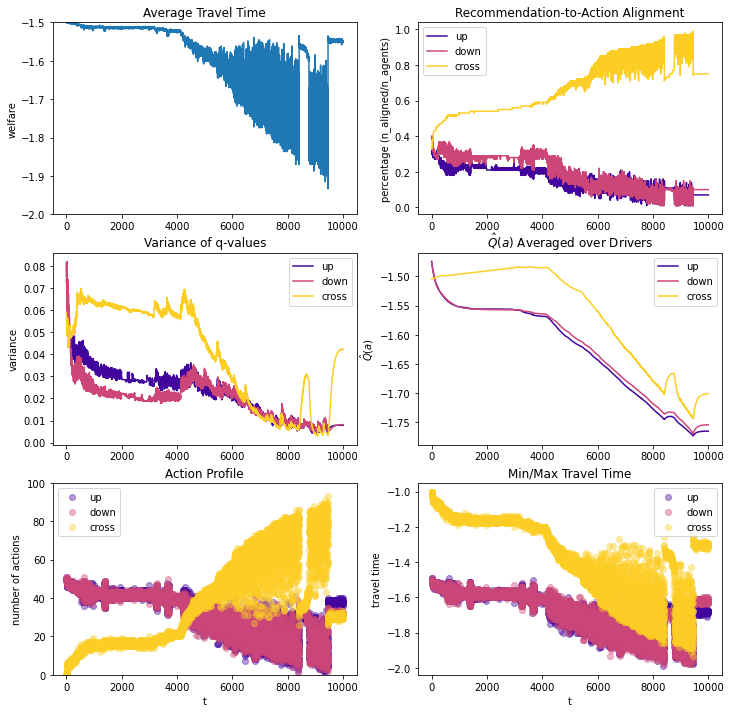

In [309]:
plot_run(M, "heuristic", N_AGENTS, N_ACTIONS, N_ITER)

no_recommender


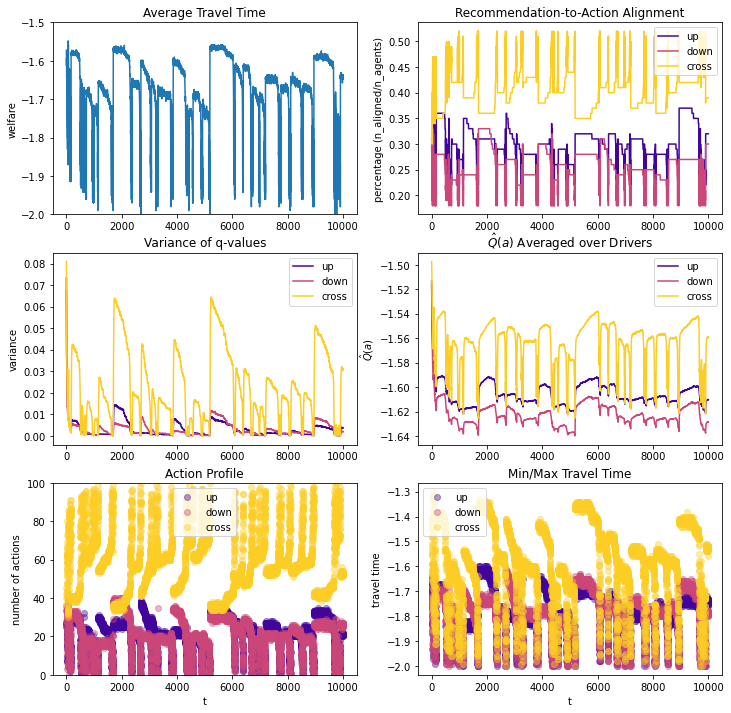

In [34]:
plot_run(M, "no_recommender", N_AGENTS, N_ACTIONS, N_ITER)

optimized_heuristic_low_alpha


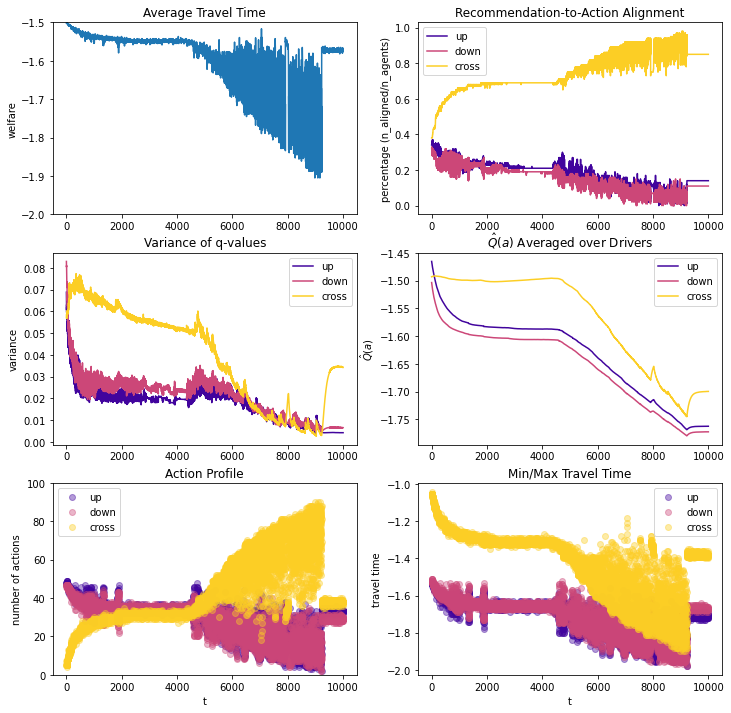

In [129]:
plot_run(M, "optimized_heuristic_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

optimized_heuristic_low_alpha_action_maximize


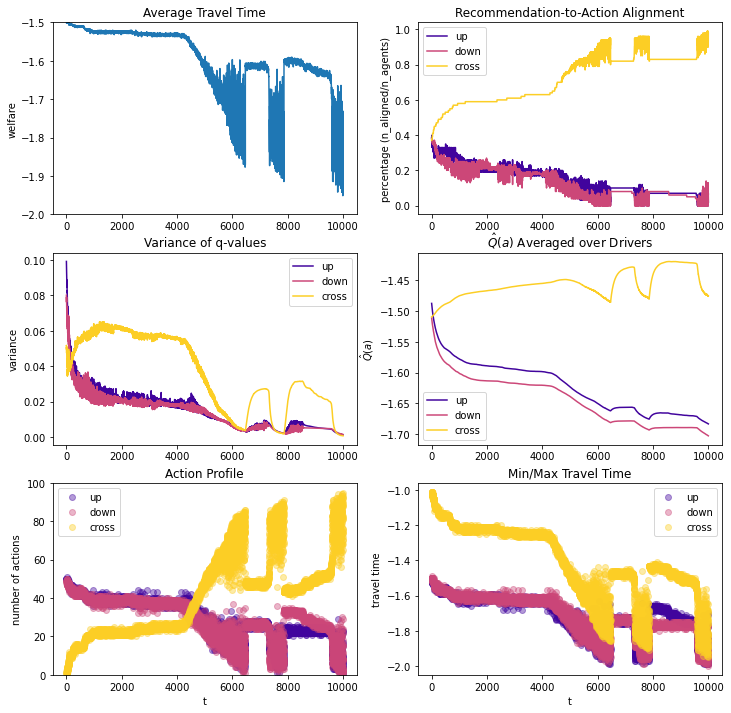

In [131]:
plot_run(M, "optimized_heuristic_low_alpha_action_maximize", N_AGENTS, N_ACTIONS, N_ITER)

optimized_heuristic_low_alpha_action_minimize


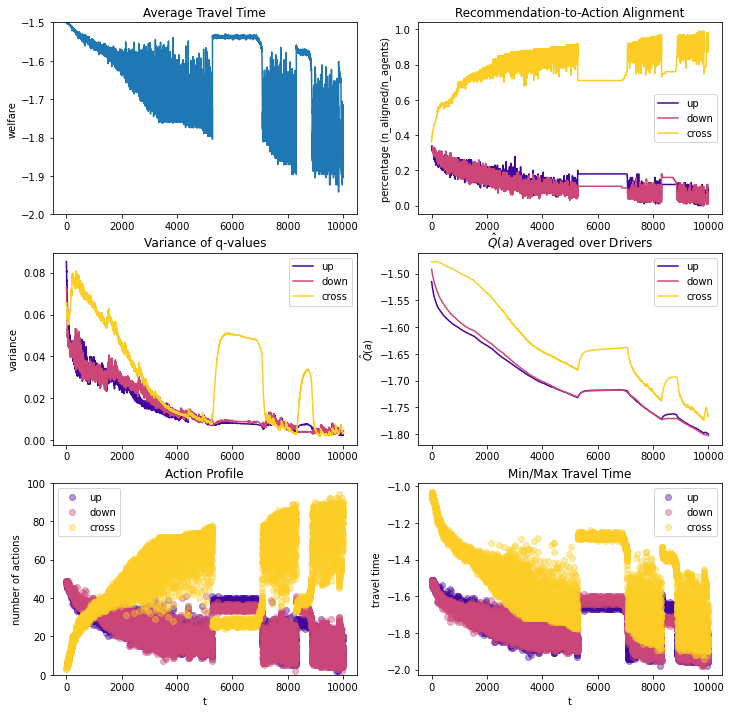

In [133]:
plot_run(M, "optimized_heuristic_low_alpha_action_minimize", N_AGENTS, N_ACTIONS, N_ITER)

optimized_heuristic_low_alpha_estimate_maximize


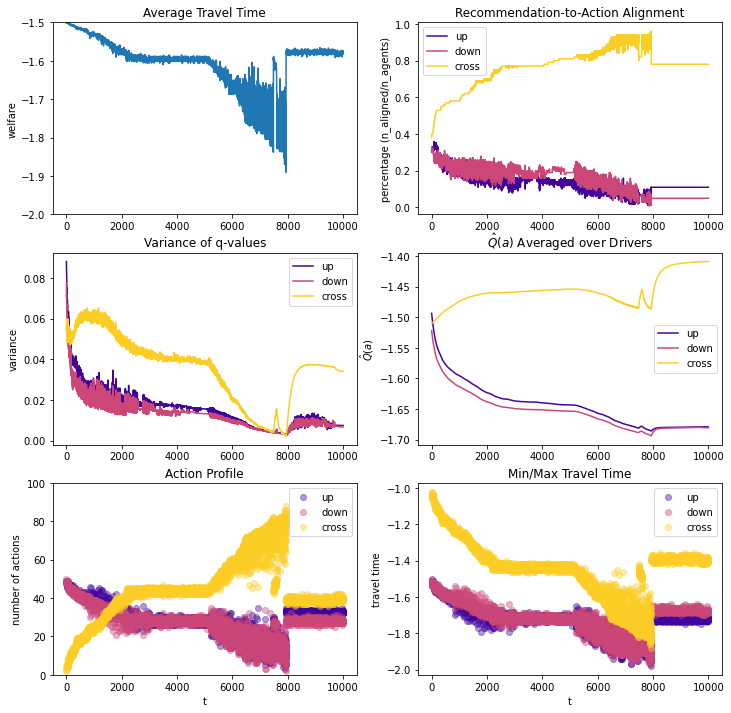

In [136]:
plot_run(M, "optimized_heuristic_low_alpha_estimate_maximize", N_AGENTS, N_ACTIONS, N_ITER)

optimized_improvement_heuristic


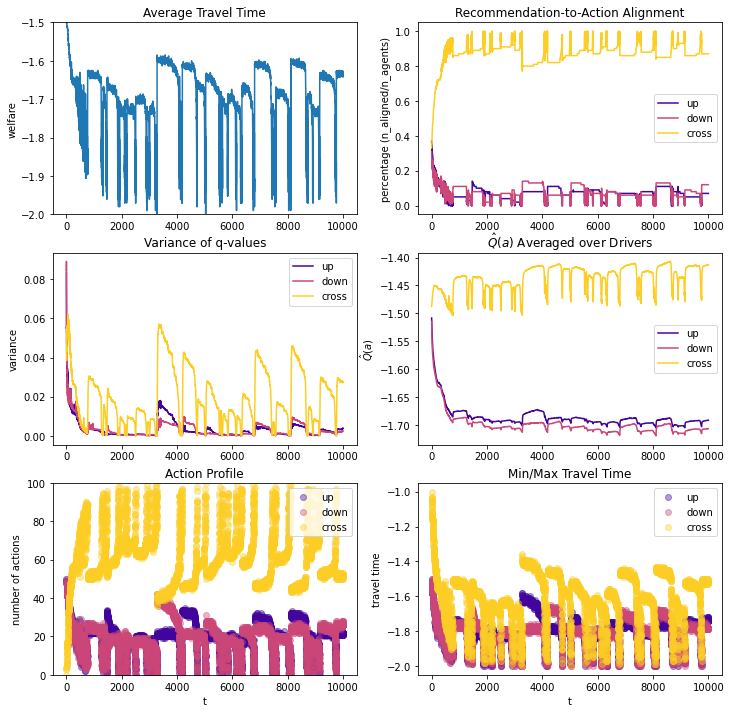

In [100]:
plot_run(M, "optimized_improvement_heuristic", N_AGENTS, N_ACTIONS, N_ITER)

optimized_improvement_heuristic_low_alpha


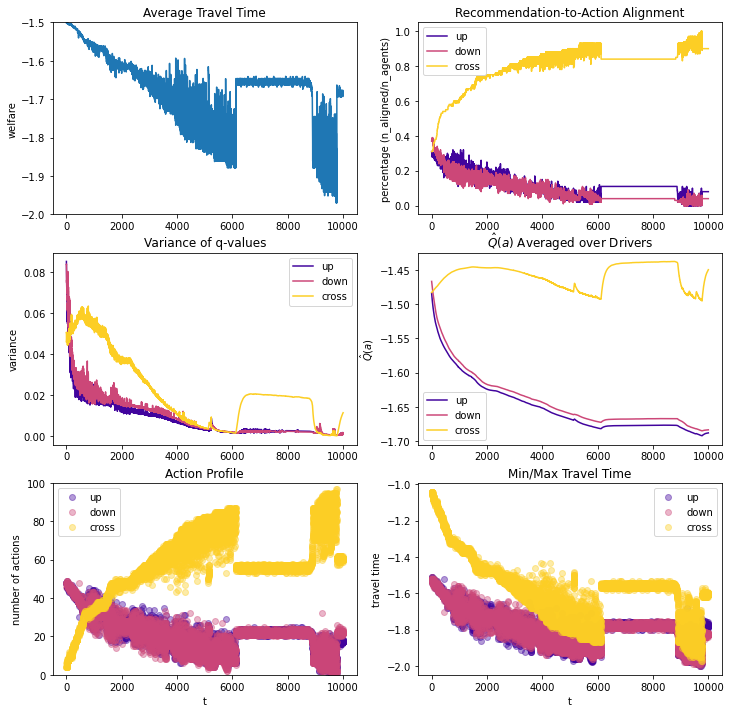

In [103]:
plot_run(M, "optimized_improvement_heuristic_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

heuristic_low_alpha


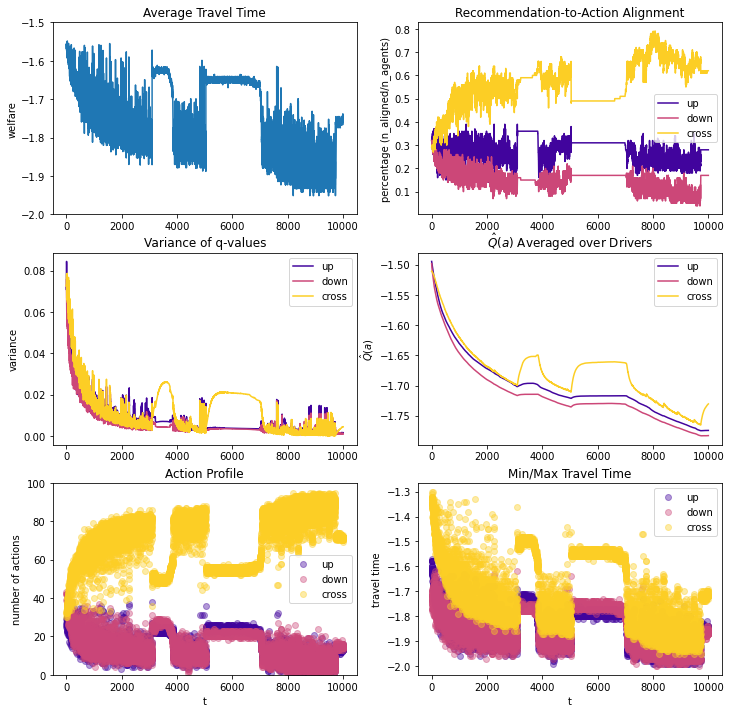

In [109]:
plot_run(M, "heuristic_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

no_recommender_low_alpha


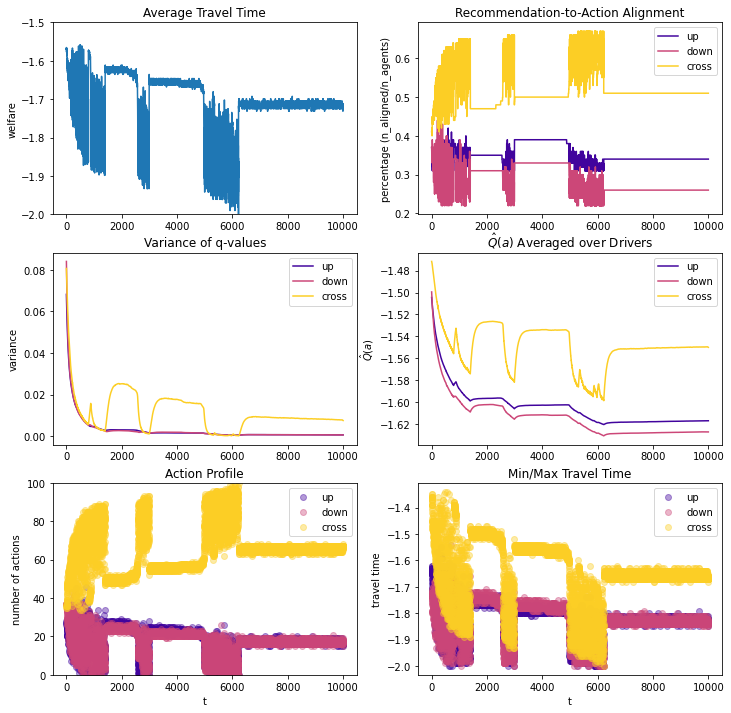

In [106]:
plot_run(M, "no_recommender_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

aligned_low_alpha


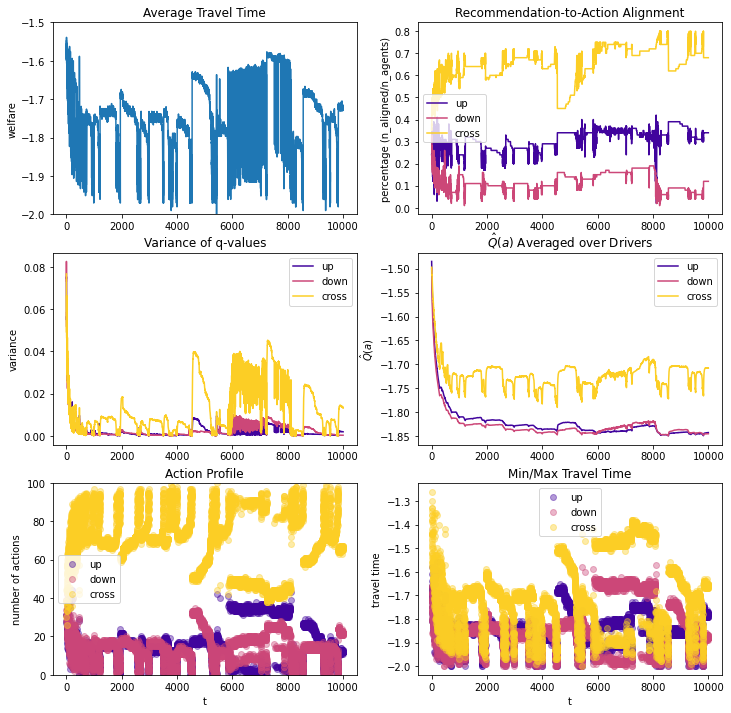

In [146]:
plot_run(M, "aligned_low_alpha", N_AGENTS, N_ACTIONS, N_ITER)

(0.0, 1.0)

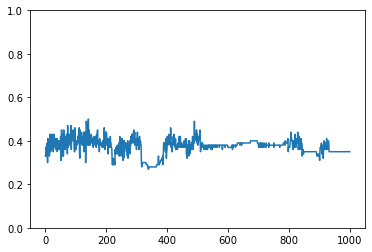

In [9]:
plt.plot([M[t]["recommendation_alignment"] for t in range(N_ITER)])
plt.ylim((0,1))

(0.0, 1.0)

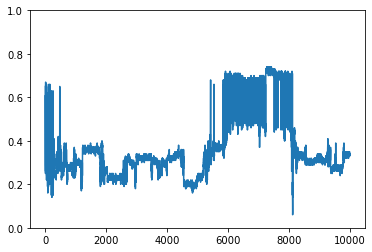

In [145]:
plt.plot([M[t]["action_alignment"] for t in range(N_ITER)])
plt.ylim((0,1))

In [ ]:
plt.plot([M[t]["Qvar"] for t in range(N_ITER)], label=["up", "down", "cross"])
plt.legend()

In [ ]:
plt.plot([M[t]["sum_of_belief_updates"] for t in range(N_ITER)])

optimized_heuristic_high_alpha_estimate_maximize


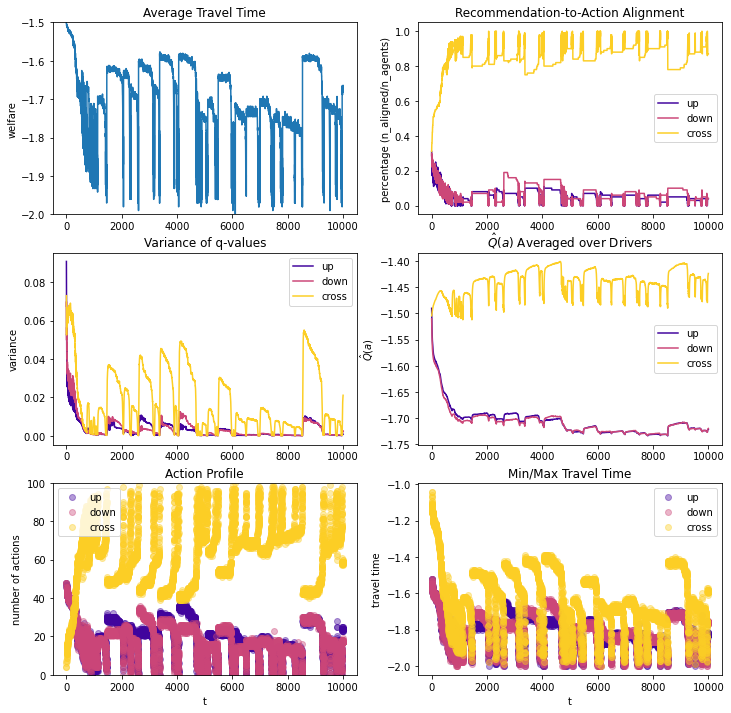

In [140]:
plot_run(M, "optimized_heuristic_high_alpha_estimate_maximize", N_AGENTS, N_ACTIONS, N_ITER)

## Two Route Game

In [ ]:
def two_route_game(A):
    n_agents = len(A)
    n_up = (A == 0).sum()
    
    r_0 = n_up/n_agents
    r_1 = 1
    T = [-r_0, -r_1]

    R = np.array([T[i] for i in A])
    return R, T

In [4]:
from routing_networks import braess_initial_network

In [55]:
def braess_initial_network(A):
    n_agents = len(A)
    n_up = (A == 0).sum()
    n_down = (A == 1).sum()

    r_0 = 1 + n_up / n_agents
    r_1 = 1 + n_down / n_agents
    T = [-r_0, -r_1]

    R = np.array([T[a] for a in A])
    return R, T

In [5]:
def initial_braess_travel_time_estimate(n_up, n_agents):
    return [
        1 + n_up/n_agents,
        1 + (n_agents - n_up)/n_agents,
    ]

In [6]:
def two_route_recommender(Q, n_agents, method="estimate", minimize=False):
    S = np.zeros(n_agents)
    arg_max_Q = np.argmax(Q, axis=2)
    
    up, down, cross, flexible = split_up_down_cross_flexible(arg_max_Q)
    
    estimate = initial_braess_travel_time_estimate(len(up), n_agents)
    
    assign_flexible_to_up_down(S, up, down, flexible, Q, arg_max_Q, method, estimate, minimize)
    
    S = assign(S, Q, arg_max_Q, up, 0, method, estimate, minimize)
    S = assign(S, Q, arg_max_Q, down, 1, method, estimate, minimize)
#     S = assign_crossers(S, arg_max_Q, cross)
#     S = assign(S, Q, arg_max_Q, cross, 2, method, estimate, (not minimize))
    
    return S.astype(int)

In [85]:
N_AGENTS = 100
N_STATES = 2
N_ACTIONS = 2
N_ITER = 500

EPSILON = 0.01
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.01

QINIT = np.array([-1.5, -1.5])
objective = total_welfare

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_48971/4217927544.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if EPSILON == "UNIFORM":


run_half_half


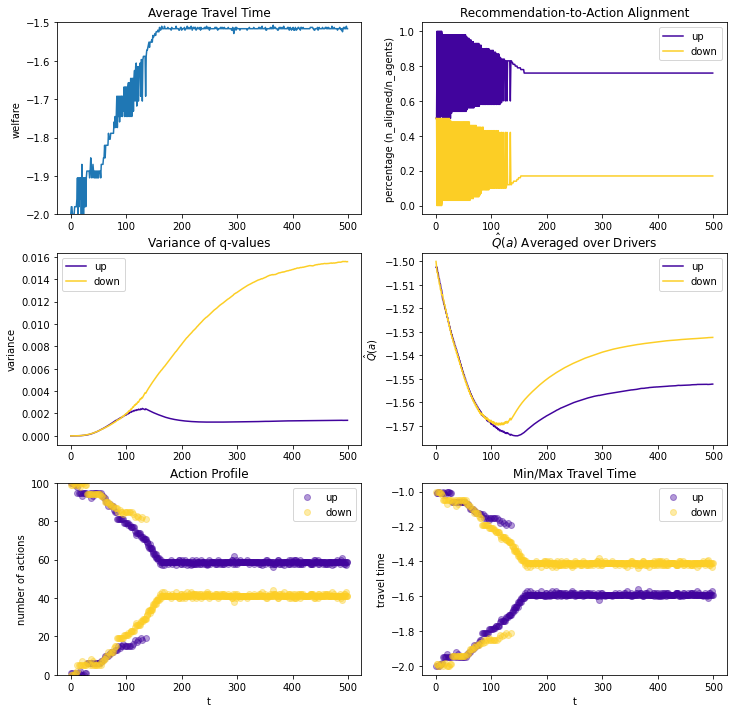

In [96]:
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)
# S = np.ones(N_AGENTS).astype(int)
# S = np.zeros(N_AGENTS).astype(int)
S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])

vectors = []

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
#     S = two_route_recommender(Q, N_AGENTS, method="estimate", minimize=False)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_initial_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }
    
#     S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])
    
NAME = f"run_half_half"

plot_run(M, NAME, N_AGENTS, N_ACTIONS, N_ITER)

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_48971/4096508363.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if EPSILON == "UNIFORM":


run_misaligned_rec


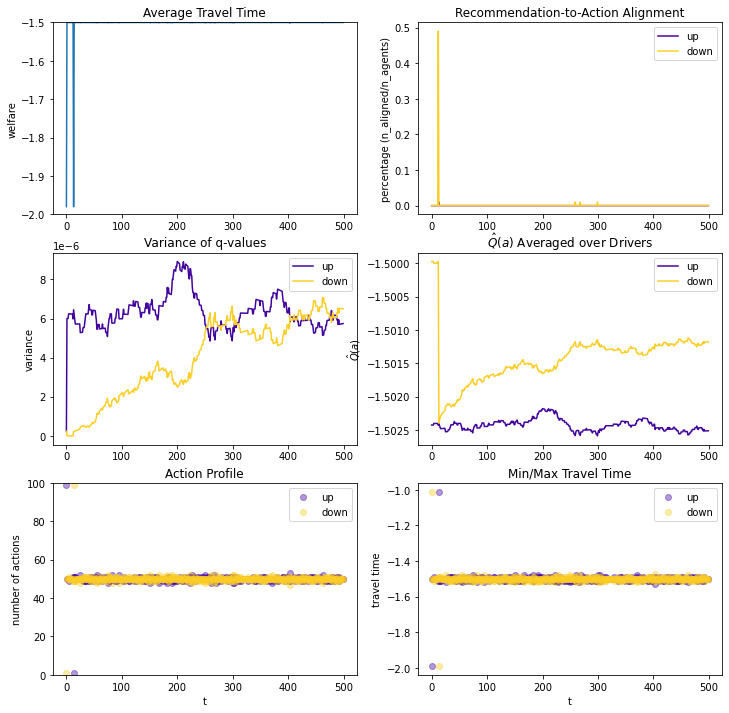

In [98]:
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M2 = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)
# S = np.ones(N_AGENTS).astype(int)
S = np.zeros(N_AGENTS).astype(int)
# S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])

vectors = []

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
#     S = two_route_recommender(Q, N_AGENTS, method="estimate", minimize=False)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_initial_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M2[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }
    
    S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])
    
NAME = f"run_misaligned_rec"

plot_run(M2, NAME, N_AGENTS, N_ACTIONS, N_ITER)

/var/folders/11/3vmp2wls5_xb0s9pfn4zdp580000gq/T/ipykernel_48971/758715389.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if EPSILON == "UNIFORM":


run_aligned_rec


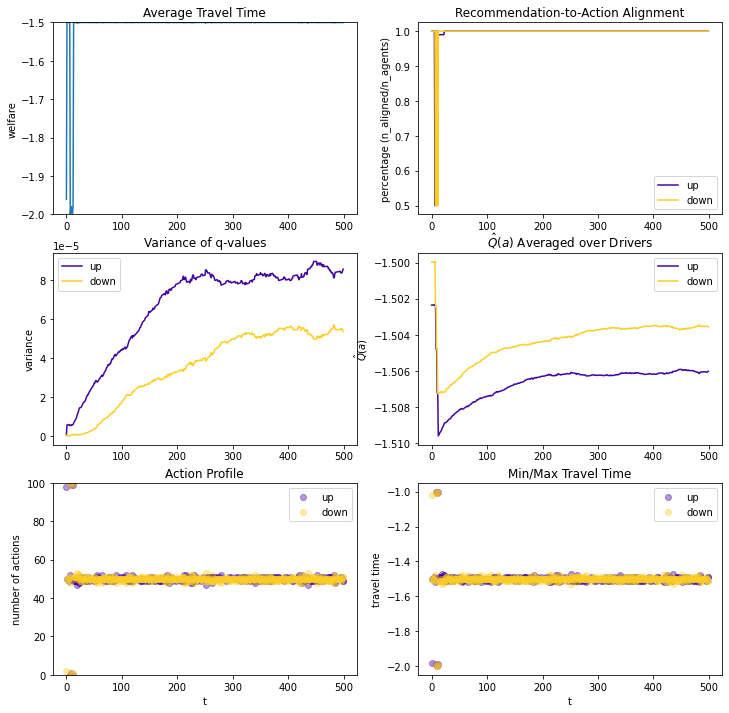

In [99]:
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M3 = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)
S = np.ones(N_AGENTS).astype(int)
# S = np.zeros(N_AGENTS).astype(int)
# S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])

vectors = []

for t in range(N_ITER):
    
#     S = naive_recommender(Q, N_AGENTS)
#     S = heuristic_recommender(Q, N_AGENTS)
#     S = aligned_heuristic_recommender(Q, N_AGENTS)
#     S = optimized_heuristic_recommender(Q, N_AGENTS, method="estimate", minimize=True)
#     S = two_route_recommender(Q, N_AGENTS, method="estimate", minimize=False)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, travel_time_per_route = braess_initial_network(A)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    ## SAVE PROGRESS DATA
    M3[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            "groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            "alignment": alignment,
            "recommendation_alignment": recommendation_alignment,
            "action_alignment": action_alignment,
           }
    
    S = np.concatenate([np.zeros(int(N_AGENTS/2)).astype(int), np.ones(int(N_AGENTS/2)).astype(int)])
    
NAME = f"run_aligned_rec"

plot_run(M3, NAME, N_AGENTS, N_ACTIONS, N_ITER)

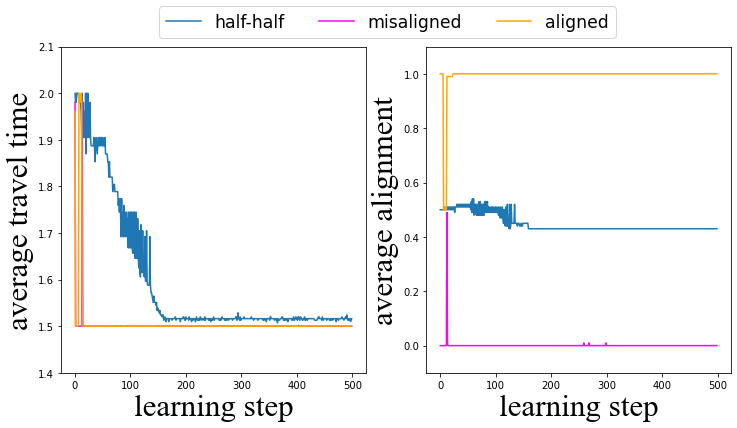

In [152]:
fig, [ax, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax.plot([-M[t]["R"].mean() for t in range(N_ITER)], color=u'#1f77b4', label="half-half")
ax.plot([-M2[t]["R"].mean() for t in range(N_ITER)], color='magenta', label="misaligned")
ax.plot([-M3[t]["R"].mean() for t in range(N_ITER)], color='orange', label="aligned")
ax.set_ylim((1.4, 2.1))
ax.set_xlabel('learning step', **{"fontname": "Times New Roman", "fontsize": "31"})
ax.set_ylabel('average travel time', **{"fontname": "Times New Roman", "fontsize": "31"})

ax2.plot([M[t]["recommendation_alignment"] for t in range(N_ITER)], color=u'#1f77b4', label="half-half")
ax2.plot([M2[t]["recommendation_alignment"] for t in range(N_ITER)], color='magenta', label="misaligned")
ax2.plot([M3[t]["recommendation_alignment"] for t in range(N_ITER)], color='orange', label="aligned")
ax2.set_ylim((-0.1, 1.1))
ax2.set_xlabel('learning step', **{"fontname": "Times New Roman", "fontsize": "31"})
ax2.set_ylabel('average alignment', **{"fontname": "Times New Roman", "fontsize": "31"})


plt.legend(fontsize="xx-large", bbox_to_anchor=(0.65, 1.15), ncol = 3)
plt.savefig("two_route_summary.png")
# plt.tight_layout()
plt.show()

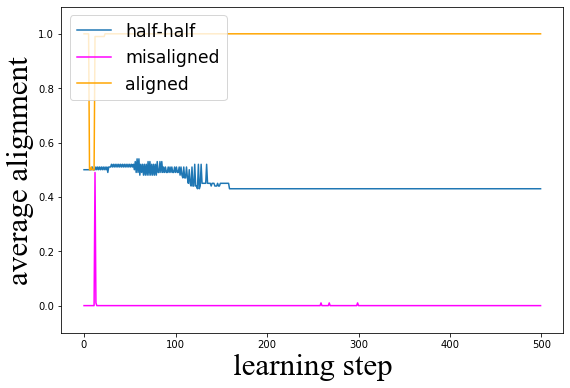

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

ax.plot([M[t]["recommendation_alignment"] for t in range(N_ITER)], color=u'#1f77b4', label="half-half")
ax.plot([M2[t]["recommendation_alignment"] for t in range(N_ITER)], color='magenta', label="misaligned")
ax.plot([M3[t]["recommendation_alignment"] for t in range(N_ITER)], color='orange', label="aligned")
ax.set_ylim((-0.1, 1.1))
plt.xlabel('learning step', **{"fontname": "Times New Roman", "fontsize": "31"})
plt.ylabel('average alignment', **{"fontname": "Times New Roman", "fontsize": "31"})
plt.legend(fontsize="xx-large")
plt.savefig("two_route_alignment.pdf")
plt.show()

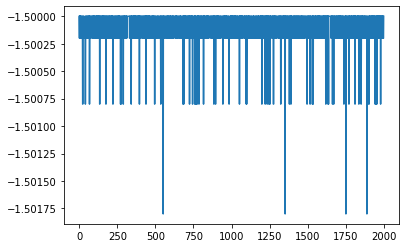

In [58]:
plt.plot([M[t]["R"].mean() for t in range(N_ITER)])

# Live Recommender Tool (needs sudo)

In [ ]:
import keyboard

In [ ]:
N_AGENTS = 100
N_STATES = 3
N_ACTIONS = 3
N_ITER = 20000

EPSILON = 0.1
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.25

QINIT = "UNIFORM"  # np.array([-2, -2, -2])

In [ ]:
Q = InitializeQTable(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

M = {}

S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

In [ ]:
# %matplotlib widget

fig = plt.figure(figsize=(10,8))
hfig = display(fig, display_id=True)
recommender_on = False

on_timesteps = []
off_timesteps = []

for t in range(N_ITER):
    if keyboard.is_pressed("r"):
        recommender_on = True
        on_timesteps.append(t)
        S = heuristic_recommender(Q, N_AGENTS)
    elif keyboard.is_pressed("e"):
        recommender_on = False
        off_timesteps.append(t)
        S = S
    
#     S = recommender_next_state(R, Q, S, A, recommender_on)
    
    A = e_greedy_select_action(Q, S, EPSILON)

    R, _ = braess_augmented_network(A)

    Q, _ = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)

    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            # "groups": count_groups(Q[ind, S, :], 0.1),
            # "Qvar": Q[ind, S, :].var(axis=0)
           }
    
    plt.clf()
    plt.plot(np.arange(0, t, 1), [M[i]["R"].mean() for i in range(t)])
#     plt.plot(on_timesteps, [M[i]["R"].mean() for i in on_timesteps])
#     plt.plot(off_timesteps, [M[i]["R"].mean() for i in off_timesteps])
#     ax2.hist(np.bincount(S))
    fig.canvas.draw()
    hfig.update(fig)
    time.sleep(0.1)
    